# Sparse Autoencoder

Implement an autoencoder with the sparsity constraint. You can build on the MLP implementation from EE5600. Choose your network size appropriately (meaning a size that you can train and test on your computer without running into memory issues).

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
# Get the MNIST data from keras and downsample
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

x_train = np.reshape(x_train, newshape=(*x_train.shape, 1))
x_train = tf.image.resize_images(images=x_train, size=(14,14))
x = tf.Session().run(x_train)
x_train = np.asarray(x, dtype=np.uint8).reshape(x_train.shape[0], 196) / 255.
# pd.DataFrame(x_train).to_csv('train.csv', sep=',', index=True, header=False)

x_test = np.reshape(x_test, newshape=(*x_test.shape, 1))
x_test = tf.image.resize_images(images=x_test, size=(14,14))
x = tf.Session().run(x_test)
x_test = np.asarray(x, dtype=np.uint8).reshape(x_test.shape[0], 196) / 255.
# pd.DataFrame(x_test).to_csv('train.csv', sep=',', index=True, header=False)

In [3]:
import matplotlib.pyplot as plt
def show_digits(x, y): # x - 196 dim vector
    x, y = np.reshape(x, (14,14)), np.reshape(y, (14,14))
    fig = plt.figure(figsize=(4, 10))
    fig.add_subplot(1,2,1)
    plt.imshow(x, cmap='gray')
    fig.add_subplot(1,2,2)
    plt.imshow(y, cmap='gray')    
    plt.show()


In [4]:
class NN(object):
    def __init__(self, input_dim, hidden_dim, learn_rate, sparsity, regularization):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = input_dim
        self.learn_rate = learn_rate
        self.s = sparsity
        self.Lambda = regularization
        # intialize weights
        self.A = np.random.normal(0,  1, (self.hidden_dim, self.input_dim))
        self.B = np.random.normal(0,  1, (self.output_dim, self.hidden_dim))
        self.a0 = np.random.normal(0, 1, self.hidden_dim)
        self.b0 = np.random.normal(0, 1, self.output_dim)

    def sigmoid(self, t):
        return 1/(1  + np.exp(-t))

    def dsigmoid(self, t):
        sigt = self.sigmoid(t)
        return sigt*(1-sigt)

    def hidden_layer(self, x):
        # A.shape:mxd; x.shape;(d,); so z.shape=(m,)
        z = self.sigmoid(np.dot(x, self.A.T) + self.a0) 
        return z

    def forward_pass(self, x):
        # B.shape:kxm; z.shape;m; so y_hat.shape=k
        y_hat = self.sigmoid(np.dot(self.hidden_layer(x), self.B.T) + self.b0)
        return y_hat
    
    def back_propogate(self, X):
        dSSE_A, dSSE_a0 = np.zeros_like(self.A), np.zeros_like(self.a0)
        dSSE_B, dSSE_b0 = np.zeros_like(self.B), np.zeros_like(self.b0)
        Z = self.hidden_layer(X) # Z.shape = (N,m)
        # print('hidden mean',Z[0].shape, np.mean(Z[0]))
        dZ = Z * (1-Z) # dZ shape = (N,m)
        # y_delta.shape (N,k)
        Y_out = self.forward_pass(X)
        y_delta = 2*(Y_out-X) * self.dsigmoid(self.b0 + np.dot(Z, self.B.T))
        # print(y_delta.shape)
        # z_delta.shape (N,m)
        z_delta = -dZ * np.matmul(y_delta, self.B) 
        # z_delta = np.transpose(-dZ.T * np.sum(y_delta, axis=1))
        zm = np.mean(Z, axis=0)
        # print(zm, zm.shape)
        # dKL shape = (N,m) 
        dKL = self.Lambda * ((-self.s/zm) + ((1-self.s)/(1-zm))) * dZ # shape: (N,m)
        #print(dKL.shape)
        dSSE_A = np.matmul((z_delta + dKL).T , X)
        #print(dSSE_A.shape)
        dSSE_a0 = np.sum((z_delta+dKL), axis=0)
        #print(dSSE_a0.shape)
        dSSE_B = np.matmul(y_delta.T, Z)
        # print('dsseB', dSSE_B.shape)
        dSSE_b0 = np.sum(y_delta, axis=0)
        # update weights 
        #print('blah', self.A.shape)
        A_new = self.A - (self.learn_rate*dSSE_A)
        a0_new = self.a0 - (self.learn_rate*dSSE_a0)
        B_new = self.B - (self.learn_rate*dSSE_B)
        b0_new = self.b0 - (self.learn_rate*dSSE_b0)
        return [A_new, a0_new, B_new, b0_new]
    
    def loss(self, X):
        y_hat = self.forward_pass(X)
        err = np.sum((X - y_hat)**2)
        zm = np.mean(self.hidden_layer(X), axis=0)
        regularizer = self.Lambda*np.sum(self.s*np.log(self.s/zm) + (1-self.s)*np.log((1-self.s)/(1-zm)))
        return err+regularizer
    
    def train(self, x_train, epochs, batch_size, shuffle=True): 
        epoch = 1
        N = len(x_train)
        while(epoch <= epochs):
            if shuffle:
                indices = np.arange(N)
                np.random.shuffle(indices)
                x_train = x_train[indices]
            
            for batch in np.arange(0, N, batch_size):
                X = x_train[batch:batch+batch_size]
                Y_hat = self.forward_pass(X)
                [self.A, self.a0, self.B, self.b0] = self.back_propogate(X)
            
            print('Epoch:', epoch, ' Loss:', self.loss(x_train))
            if epoch%5==0: show_digits(X[0], Y_hat[0])
            epoch += 1
        print('Done Training')
    

Epoch: 1  Loss: 3407325.082509505
Epoch: 2  Loss: 2521522.8028088263
Epoch: 3  Loss: 1988789.9843748123
Epoch: 4  Loss: 1683256.3988761008
Epoch: 5  Loss: 1515730.848666568


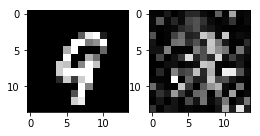

Epoch: 6  Loss: 1421006.3033429259
Epoch: 7  Loss: 1355232.9699962062
Epoch: 8  Loss: 1306465.1684278967
Epoch: 9  Loss: 1270838.0440949847
Epoch: 10  Loss: 1244178.811643471


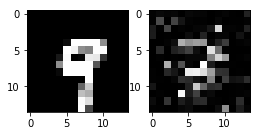

Epoch: 11  Loss: 1223127.10397872
Epoch: 12  Loss: 1205638.195798248
Epoch: 13  Loss: 1190462.8974223647
Epoch: 14  Loss: 1176859.316793546
Epoch: 15  Loss: 1164689.5842960184


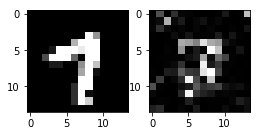

Epoch: 16  Loss: 1153424.5467674464
Epoch: 17  Loss: 1142898.100987152
Epoch: 18  Loss: 1132997.0410895254
Epoch: 19  Loss: 1123710.986934633
Epoch: 20  Loss: 1114891.0561930567


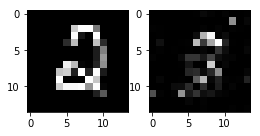

Epoch: 21  Loss: 1106631.7135331195
Epoch: 22  Loss: 1098907.1195020769
Epoch: 23  Loss: 1091631.6286849042
Epoch: 24  Loss: 1084840.32619744
Epoch: 25  Loss: 1078404.7390974488


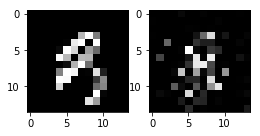

Epoch: 26  Loss: 1072370.0611686718
Epoch: 27  Loss: 1066677.4298659393
Epoch: 28  Loss: 1061147.807939419
Epoch: 29  Loss: 1055693.6177100474
Epoch: 30  Loss: 1050391.0788525918


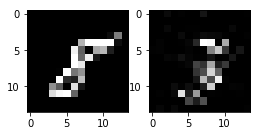

Epoch: 31  Loss: 1045004.4857326591
Epoch: 32  Loss: 1039697.9347317629
Epoch: 33  Loss: 1034490.276565849
Epoch: 34  Loss: 1029414.6206203277
Epoch: 35  Loss: 1024104.670261063


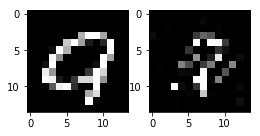

Epoch: 36  Loss: 1018888.9454229226
Epoch: 37  Loss: 1013673.8701273832
Epoch: 38  Loss: 1008281.0501513783
Epoch: 39  Loss: 1002828.8784572968
Epoch: 40  Loss: 997455.3498310784


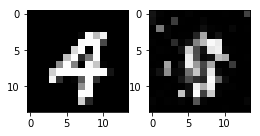

Epoch: 41  Loss: 991933.4692121663
Epoch: 42  Loss: 986532.9949730263
Epoch: 43  Loss: 981109.8202822082
Epoch: 44  Loss: 975731.9480051742
Epoch: 45  Loss: 970429.4655701125


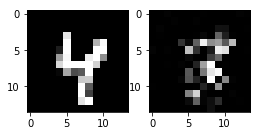

Epoch: 46  Loss: 965149.4172445069
Epoch: 47  Loss: 959898.4633710041
Epoch: 48  Loss: 954867.165599139
Epoch: 49  Loss: 949801.7605808891
Epoch: 50  Loss: 944715.7530587686


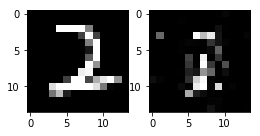

Epoch: 51  Loss: 939825.0442731708
Epoch: 52  Loss: 935092.5519744791
Epoch: 53  Loss: 930397.7677216694
Epoch: 54  Loss: 925841.1025981696
Epoch: 55  Loss: 921351.0616949034


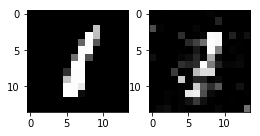

Epoch: 56  Loss: 916896.6581861752
Epoch: 57  Loss: 912412.9992156766
Epoch: 58  Loss: 908075.6575297102
Epoch: 59  Loss: 903762.4622409914
Epoch: 60  Loss: 899604.6871992362


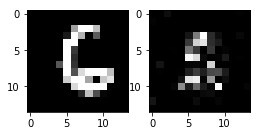

Epoch: 61  Loss: 895521.2083169362
Epoch: 62  Loss: 891542.1703054535
Epoch: 63  Loss: 887648.9159308949
Epoch: 64  Loss: 883961.6552746771
Epoch: 65  Loss: 880433.1901543041


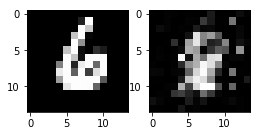

Epoch: 66  Loss: 877111.3216189204
Epoch: 67  Loss: 873858.5519047687
Epoch: 68  Loss: 870626.0538722115
Epoch: 69  Loss: 867474.5909523445
Epoch: 70  Loss: 864461.4473966304


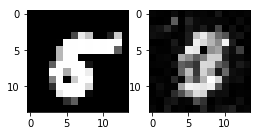

Epoch: 71  Loss: 861560.1522255616
Epoch: 72  Loss: 858923.7476017699
Epoch: 73  Loss: 856505.8072496428
Epoch: 74  Loss: 854405.7122966489
Epoch: 75  Loss: 852561.7500061857


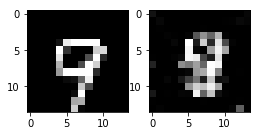

Epoch: 76  Loss: 850944.7649231674
Epoch: 77  Loss: 849586.335735832
Epoch: 78  Loss: 848537.3104931208
Epoch: 79  Loss: 847703.4670797333
Epoch: 80  Loss: 847144.9049790504


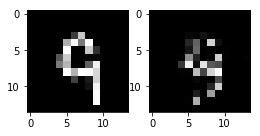

Epoch: 81  Loss: 846878.9412701994
Epoch: 82  Loss: 846808.0818790001
Epoch: 83  Loss: 847072.2416907446
Epoch: 84  Loss: 847541.3444938328
Epoch: 85  Loss: 848405.0977697725


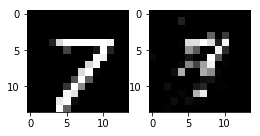

Epoch: 86  Loss: 849574.8640100841
Epoch: 87  Loss: 851039.5099768295
Epoch: 88  Loss: 852774.9904330091
Epoch: 89  Loss: 854481.9438340811
Epoch: 90  Loss: 855754.7700129403


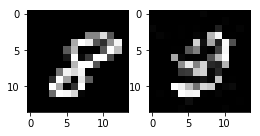

Epoch: 91  Loss: 856321.5973052391
Epoch: 92  Loss: 856123.912410974
Epoch: 93  Loss: 854901.7958790532
Epoch: 94  Loss: 852825.8378586839
Epoch: 95  Loss: 850296.8549950231


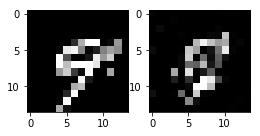

Epoch: 96  Loss: 847534.4271553666
Epoch: 97  Loss: 845148.7532448132
Epoch: 98  Loss: 843313.7411555011
Epoch: 99  Loss: 842023.5904774802
Epoch: 100  Loss: 841216.6313911052


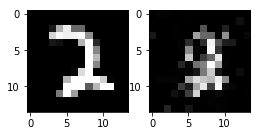

Epoch: 101  Loss: 840839.8286140343
Epoch: 102  Loss: 840600.3704864918
Epoch: 103  Loss: 840133.6808459212
Epoch: 104  Loss: 839078.8753253457
Epoch: 105  Loss: 837347.301076661


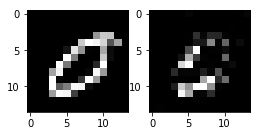

Epoch: 106  Loss: 834922.2606085117
Epoch: 107  Loss: 832041.5802726712
Epoch: 108  Loss: 828894.8482816184
Epoch: 109  Loss: 825965.9843302305
Epoch: 110  Loss: 823263.0113938402


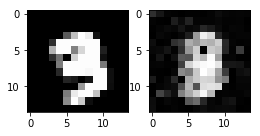

Epoch: 111  Loss: 820995.9770309892
Epoch: 112  Loss: 819300.0954155666
Epoch: 113  Loss: 818362.9057104385
Epoch: 114  Loss: 818172.1218342136
Epoch: 115  Loss: 818160.8428820602


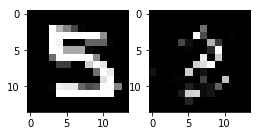

Epoch: 116  Loss: 817774.0987453017
Epoch: 117  Loss: 816987.3293203914
Epoch: 118  Loss: 815813.3088501586
Epoch: 119  Loss: 814194.5265023669
Epoch: 120  Loss: 812380.9566392568


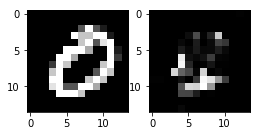

Epoch: 121  Loss: 810495.4829706866
Epoch: 122  Loss: 808777.9957730077
Epoch: 123  Loss: 807266.0947246755
Epoch: 124  Loss: 806108.0556949413
Epoch: 125  Loss: 805126.5357392323


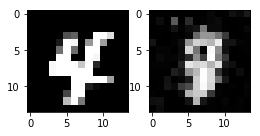

Epoch: 126  Loss: 804585.3090954312
Epoch: 127  Loss: 804767.9621846287
Epoch: 128  Loss: 805465.044998575
Epoch: 129  Loss: 805899.1661644656
Epoch: 130  Loss: 806053.9447520603


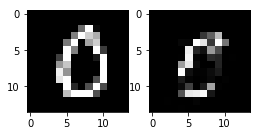

Epoch: 131  Loss: 805880.208075814
Epoch: 132  Loss: 804652.4043041294
Epoch: 133  Loss: 801779.3658969343
Epoch: 134  Loss: 796349.187897318
Epoch: 135  Loss: 789215.9144802255


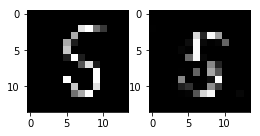

Epoch: 136  Loss: 781656.9758917562
Epoch: 137  Loss: 774538.3853529453
Epoch: 138  Loss: 768217.2523008218
Epoch: 139  Loss: 762787.4228734825
Epoch: 140  Loss: 757985.0150498487


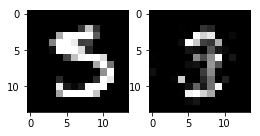

Epoch: 141  Loss: 753766.6869346917
Epoch: 142  Loss: 750098.6617163836
Epoch: 143  Loss: 746880.9472254298
Epoch: 144  Loss: 744179.8124079605
Epoch: 145  Loss: 741922.6197648738


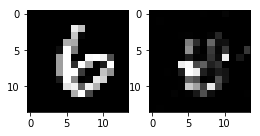

Epoch: 146  Loss: 740078.3705044902
Epoch: 147  Loss: 738649.7592553105
Epoch: 148  Loss: 737536.1433215956
Epoch: 149  Loss: 736663.9799360627
Epoch: 150  Loss: 736086.2673781596


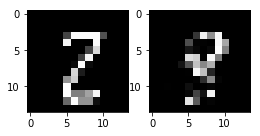

Done Training


In [5]:
SparseAE1 = NN(input_dim=196, hidden_dim=225, learn_rate=1e-4, sparsity=0.1, regularization=1)

SparseAE1.train(x_train=x_train, epochs=150, batch_size=300, shuffle=True)


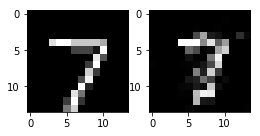

0.10804155687104096


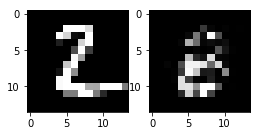

0.10706568864178621


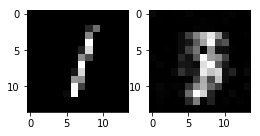

0.04438378954587863


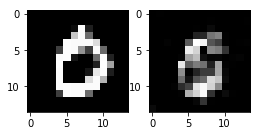

0.07812827369433466


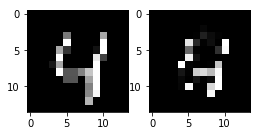

0.24219476162175088


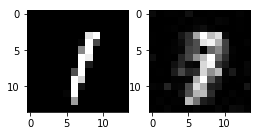

0.03698334492562646


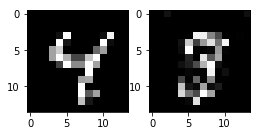

0.11169565418209196


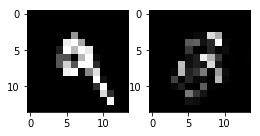

0.11077972516025704


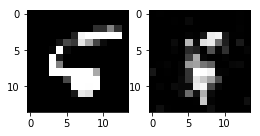

0.07861361600834271


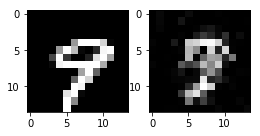

0.05447443578483974


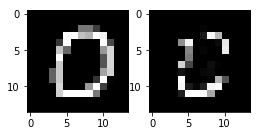

0.27525204463379865


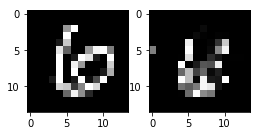

0.15758808492413953


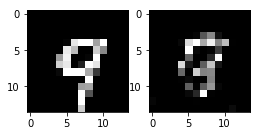

0.1080428916632512


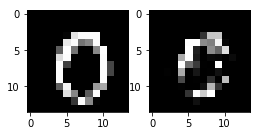

0.17724502976593853


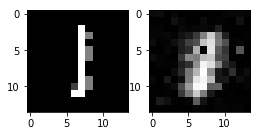

0.01766655229455818


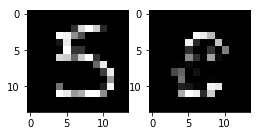

0.20994485017992578


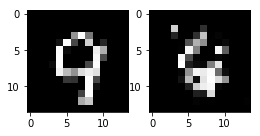

0.1150866776826784


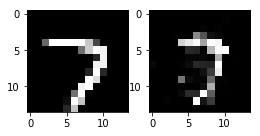

0.11629129932475868


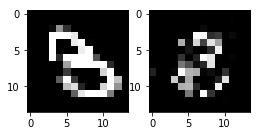

0.13448447366680893


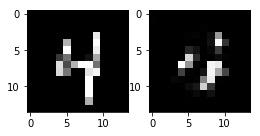

0.14221013550821868


In [6]:
for i in range(20):
    test_out = SparseAE1.forward_pass(x_test[i])
    test_rep = SparseAE1.hidden_layer(x_test[i])
    show_digits(x_test[i], test_out)
    print(test_rep.mean()) # this mean should be close to the chosen sparsity

Epoch: 1  Loss: 2416632.2022379735
Epoch: 2  Loss: 1640434.222192323
Epoch: 3  Loss: 1398468.8903922003
Epoch: 4  Loss: 1289757.5693635629
Epoch: 5  Loss: 1228525.1434272393


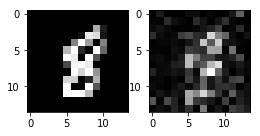

Epoch: 6  Loss: 1188596.0693782875
Epoch: 7  Loss: 1158920.0670737205


In [ ]:
SparseAE2 = NN(input_dim=196, hidden_dim=256, learn_rate=2e-4, sparsity=0.05, regularization=2)

SparseAE2.train(x_train=x_train, epochs=150, batch_size=300, shuffle=True)


In [ ]:
for i in range(20):
    test_out = SparseAE2.forward_pass(x_test[i])
    test_rep = SparseAE2.hidden_layer(x_test[i])
    show_digits(x_test[i], test_out)
    print(test_rep.mean()) # this mean should be close to the chosen sparsity